In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, avg, stddev
import numpy as np

spark = SparkSession.builder.appName("MonteCarloStockSimulation").getOrCreate()

In [17]:
data_pat = "/home/hadoop/Documents/historical_stock_data.csv"
print(data_pat)

/home/hadoop/Documents/historical_stock_data.csv


In [18]:
import pandas as pd
df_pandas = pd.read_csv(data_pat)
df = spark.createDataFrame(df_pandas)

df.show()

+----------+------------------+------------------+------------------+-----------------+------------------+---------+
|      Date|              Open|              High|               Low|            Close|         Adj Close|   Volume|
+----------+------------------+------------------+------------------+-----------------+------------------+---------+
|2019-01-02| 38.72249984741211|39.712501525878906|38.557498931884766|39.47999954223633| 37.75008392333984|148158800|
|2019-01-03|35.994998931884766| 36.43000030517578|              35.5|35.54750061035156| 33.98989486694336|365248800|
|2019-01-04| 36.13249969482422| 37.13750076293945| 35.95000076293945|37.06499862670898| 35.44091033935547|234428400|
|2019-01-07| 37.17499923706055| 37.20750045776367| 36.47499847412109|36.98249816894531| 35.36201477050781|219111200|
|2019-01-08| 37.38999938964844| 37.95500183105469|37.130001068115234|          37.6875|36.036128997802734|164101200|
|2019-01-09|  37.8224983215332| 38.63249969482422|37.40750122070

In [19]:
df_close = df.select("Date", "Close")


window_spec = Window.orderBy("Date")

df_close_lag = df_close.withColumn("prev_close", lag(col("Close"), 1).over(window_spec))

df_returns = df_close_lag.withColumn("daily_return", 
                                     (col("Close") - col("prev_close")) / col("prev_close"))

df_returns_clean = df_returns.na.drop()

stats = df_returns_clean.agg(
    avg("daily_return").alias("mean_return"),
    stddev("daily_return").alias("stddev_return")
).collect()[0]

mean_return = stats["mean_return"]
stddev_return = stats["stddev_return"]


num_simulations = 1000  
num_days = 252  

24/10/21 10:00:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/21 10:00:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/21 10:00:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/21 10:00:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [20]:
last_close_price = df_close.orderBy(col("Date").desc()).first()["Close"]

simulations = []

for sim in range(num_simulations):
    prices = [last_close_price]
    
    for day in range(num_days):
        daily_return = np.random.normal(mean_return, stddev_return)
        next_price = prices[-1] * (1 + daily_return)
        prices.append(next_price)
    
    simulations.append(prices)


sim_rdd = spark.sparkContext.parallelize(simulations)
sim_df = sim_rdd.toDF()

sim_df.show(5)


+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------

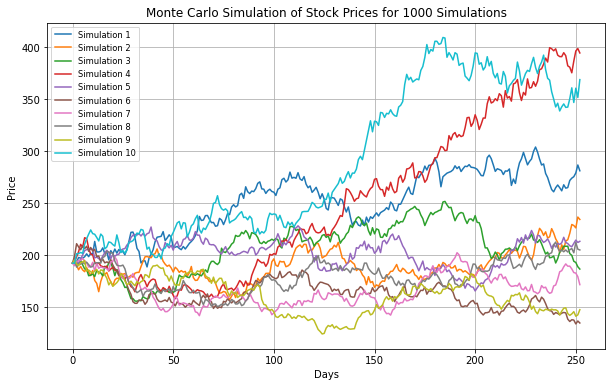

In [21]:
import matplotlib.pyplot as plt
simulations_array = np.array(simulations)

plt.figure(figsize=(10,6))

for i in range(10):
    plt.plot(simulations_array[i], label=f'Simulation {i+1}')

plt.title(f"Monte Carlo Simulation of Stock Prices for {num_simulations} Simulations")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.legend(loc='upper left', fontsize='small')
plt.show()


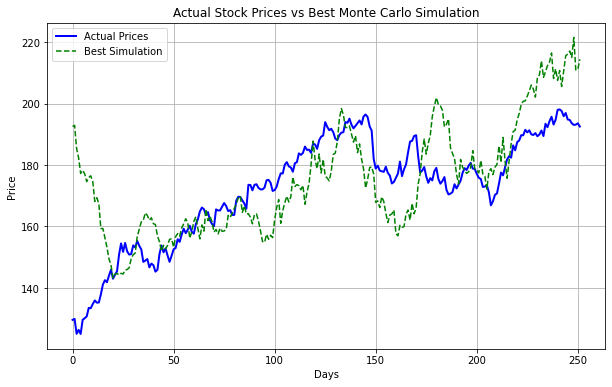

In [22]:
actual_prices = df_close.orderBy("Date").select("Close").rdd.flatMap(lambda x: x).collect()[-num_days:]

mae_values = []
for i in range(num_simulations):
    simulation_prices = simulations_array[i]
    mae = np.mean(np.abs(np.array(actual_prices) - np.array(simulation_prices[:num_days])))
    mae_values.append(mae)

best_simulation_index = np.argmin(mae_values)
best_simulation = simulations_array[best_simulation_index]

plt.figure(figsize=(10,6))

plt.plot(actual_prices, label='Actual Prices', color='blue', linewidth=2)

plt.plot(best_simulation[:num_days], label='Best Simulation', color='green', linestyle='--')

plt.title("Actual Stock Prices vs Best Monte Carlo Simulation")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.legend(loc='upper left', fontsize='medium')
plt.show()

spark.stop()


In [25]:
print(f"Mean squared value : {min(mae_values)}")

Mean squared value : 11.85373074924762
